In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import itertools, more_itertools
import swifter
import re

In [2]:
from utilities import *

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 100)
plt.ioff()

sns.set_context('talk')
sns.set_style('darkgrid', {'patch.edgecolor' : 'none', 'patch.force_edgecolor' : False})

# Load the Data
The first task will be classify the columns as:
- irrelevant
- categorical predictor (including boolean)
- ordinal predictor
- main target
- subsidiary target (questions that obviously reveal the answer to the main target)

I highly recommend you look at the codebook with a spreadsheet viewer and not the dataframe itself

In [4]:
df       = pd.read_csv('dataset.csv' , index_col = 0)
codebook = pd.read_csv('codebook.csv', index_col = 0)

# Classify the Columns

## The Target Variable

Target variables:

- Questions 36–40 are explicitly career-plan related and contain our target
- Questions 41–54 have the potential to be quite career related and need to be screened for data leakage

In [5]:
def getQs(q):
    all_qs = codebook.index
    qs     = lfilter(lambda row : re.match(q, row), all_qs)
    return codebook.loc[qs]

In [6]:
getQs('Q38')

,Question Text,var_type,checkbox_text,notes,num_categories,num_missing
Q38.a,Research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,82
Q38.b,Research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,135
Q38.c,Research within government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,196
Q38.d,Non-research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,223
Q38.e,Medical research,Ordinal,NaN,Likelihood of pursuing career path,6,185
Q38.f,Non-research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,262
Q38.g,Non-research in government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,290


In [7]:
def getQNum(q):
    num = re.match('Q(\d*)', q)
    if not num:
        return None
    num = int(num.group(1))
    return num

In [8]:
def filterQRange(low, hi, exclude = True):
    def filterQ(q):
        n = getQNum(q)
        if not n:
            return exclude
        else:
            if low <= n <= hi:
                return not exclude
            else:
                return exclude
    
    return filterQ

The target will be anyone likely or very likely (4 or 5) to pursue research in academia

In [9]:
target_all = (df['Q38.a'] >= 4).rename('Academic Research Likely')
print(f'{sum(target_all)/len(target_all) : .1%} are Likely to Pursue Academic Research')

 71.0% are Likely to Pursue Academic Research


In [10]:
def bar_plot(col, name=''):
    return plot(sns.countplot, y = df[col].rename(name), hue = target_all)

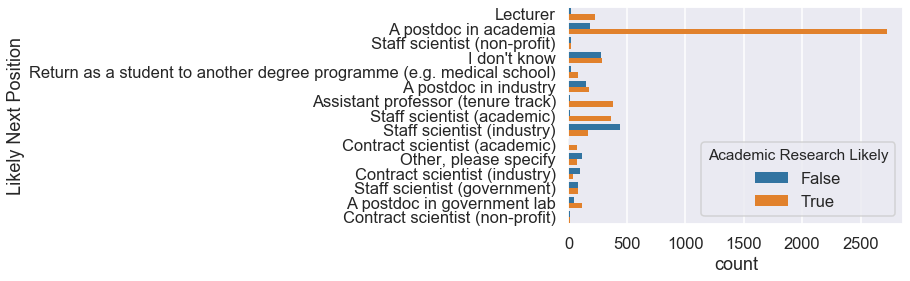

In [11]:
bar_plot('Q40', 'Likely Next Position')

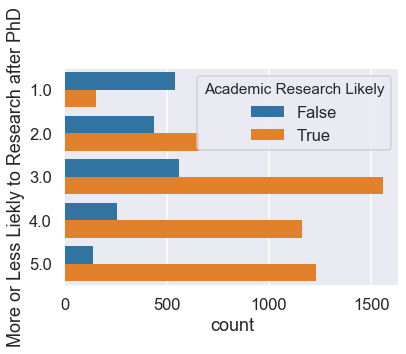

In [12]:
bar_plot('Q43.a', 'More or Less Liekly to Research after PhD')

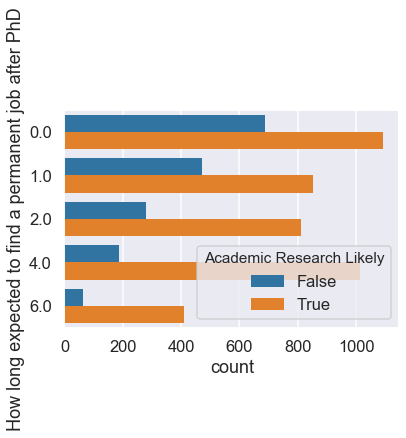

In [13]:
bar_plot('Q42', 'How long expected to find a permanent job after PhD')

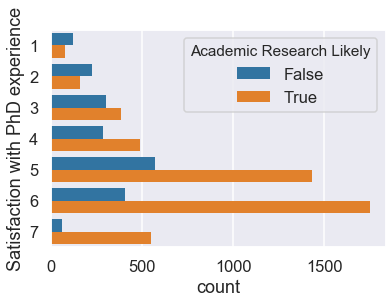

In [14]:
bar_plot('Q19.a', 'Satisfaction with PhD experience')

In [15]:
def checkbox_plot(q, label_col = 'checkbox_text'):
    qs           = getQs(q)
    title        = qs['Question Text'].iloc[0]
    labels       = qs[label_col].rename(title)
    data         = df[qs.index]
    data.columns = labels
    data         = pd.concat([data, target_all], axis = 'columns')
    data = data.melt(id_vars='Academic Research Likely', var_name=title)
    data = data[data.value]
    return plot(sns.countplot, y = title, data = data, hue = 'Academic Research Likely')

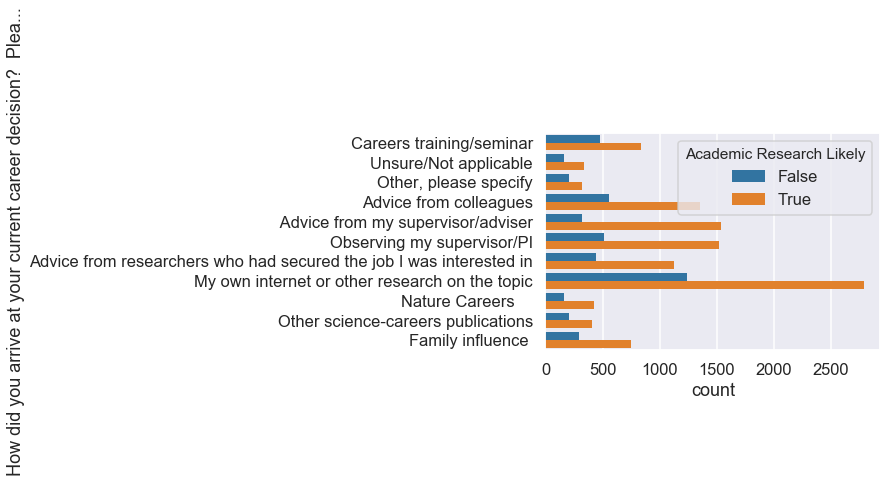

In [16]:
checkbox_plot('Q45')

# Model Building

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [19]:
import sklearn.preprocessing as pre
import sklearn.pipeline      as pipe
import sklearn.impute        as imp
import sklearn.compose       as pipe2
import sklearn.dummy         as dum

## Setup

In [20]:
codebook.var_type.value_counts()

Check Box      122
Ordinal         80
Categorical     17
Boolean          4
Name: var_type, dtype: int64

In [21]:
# Prevent Data Leakage
leakage_filter = filterQRange(36, 54)

categorical_vars = codebook[codebook.var_type.isin(['Boolean', 'Categorical'])].index.tolist()
categorical_vars = lfilter(leakage_filter, categorical_vars)
categorical_vars.remove('ID.site') # Quite irrelevant

ordinal_vars = codebook[codebook.var_type == 'Ordinal'].index.tolist()
ordinal_vars = lfilter(leakage_filter, ordinal_vars)

checkbox_vars = codebook[codebook.var_type == 'Check Box'].index.tolist()
checkbox_vars = lfilter(leakage_filter, checkbox_vars)

In [22]:
X_all = df.loc[:,categorical_vars + ordinal_vars + checkbox_vars]

In [23]:
X_all.loc[:,checkbox_vars]    = X_all[checkbox_vars].astype(int)
X_all.loc[:,categorical_vars] = X_all[categorical_vars].astype(str)

In [24]:
X_train, X_test, target_train, target_test = train_test_split(X_all, target_all, random_state = 42)

#Aliases
X      = X_train
target = target_train
y      = target_train
y_test = target_test

## Baseline Model

In [25]:
print(f'''{dum.DummyClassifier(strategy = 'most_frequent').fit(X, y).score(X_test, y_test) : .1%}''')

 70.8%


## First Model

For the ordinal variables we need to impute.

For the rankings, impute to bottom

For the 1-5 scales, impute to most common

In [26]:
# Identify the ranking variables
ordinal_book     = codebook.loc[ordinal_vars]
ranking_book     = ordinal_book[ordinal_book.notes.str.contains('[rR]anking').fillna(False)]
ranking_vars     = ranking_book.index.tolist()
non_ranking_vars = list_diff(ordinal_vars, ranking_vars)

In [27]:
# We can fill with bottom = 14
X[ranking_vars].max().value_counts()

14.0    14
dtype: int64

In [28]:
cleaner = pipe2.ColumnTransformer([
    ('bottom', imp.SimpleImputer(strategy = 'constant', fill_value = 14), ranking_vars),
    ('freq'  , imp.SimpleImputer(strategy = 'most_frequent')            , non_ranking_vars),  
    ('onehot', pre.OneHotEncoder(drop = 'first', sparse = 'false')      , categorical_vars)],
remainder = 'passthrough')

In [29]:
learner = LogisticRegression(max_iter = 10000)

In [30]:
model = pipe.Pipeline([
    ('clean'  , cleaner),
    ('log_reg', learner)
])

In [31]:
Timer.start()
model.fit(X, y)
Timer.end()

4.308 seconds elapsed


In [32]:
learner = dict(model.steps)['log_reg']

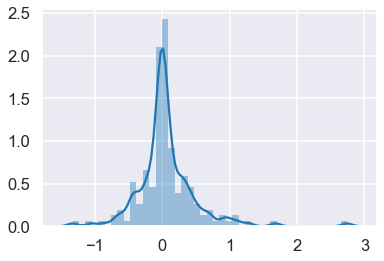

In [34]:
plot(sns.distplot, learner.coef_)

In [35]:
# Accuracy
print(f'{model.score(X_test, target_test) : .1%}')

 79.6%
